In [1]:
import numpy as np
import pandas as pd
import glob
import pystan
import re
import matplotlib.pyplot as plt
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive
from player_model import PlayerModel

In [2]:
player_list = glob.glob(f'./data/data/2020-21/players/*')

In [3]:
id_player_dict = {}

for row in player_list:
    idx = int(re.findall('[0-9]+', row)[-1])
    player_name = row.split('/')[-1]
    
    id_player_dict[idx] = player_name

In [4]:
li = []

for player in player_list:
    idx = int(re.findall('[0-9]+', player)[-1])
    df = pd.read_csv(player + '/gw.csv', usecols=['goals_scored',
                                                  'assists',
                                                  'clean_sheets',
                                                  'minutes',
                                                  'team_a_score',
                                                  'team_h_score',
                                                  'was_home'], nrows=38).assign(player_id=idx)
    
    
    if df.shape[0] == 38:
        df['gw'] = np.arange(1, 39).reshape(-1,1)
        li.append(df)
        
    elif df.shape[0] < 38:
        for _ in range(38 - df.shape[0]):
            df = df.append(pd.Series([0,0,0,0,0,0,False,idx], index=df.columns), ignore_index=True)
        df['gw'] = np.arange(1,39).reshape(-1,1)
        li.append(df)
    else:
        continue
    assert df.shape == (38, 9), 'Not all dfs are the same shape'

data = pd.concat(li, axis=0, ignore_index=True)

In [5]:
data['team_goals'] = data['team_h_score'] * (data['was_home'] == True) + data['team_a_score'] * (data['was_home'] == False)

INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [6]:
element_type = pd.read_csv('./data/data/2020-21/players_raw.csv', usecols=['id', 'element_type'])
element_team = pd.read_csv('./data/data/2020-21/players_raw.csv', usecols=['id', 'team'])

In [7]:
data = data.merge(element_type, left_on='player_id', right_on='id', how='outer')

In [8]:
element_type_dict = {1 : 'GKP', 2 : 'DEF', 3 : 'MID', 4: 'FWD'}

In [9]:
data['element_type'] = data['element_type'].map(element_type_dict)

In [10]:
def get_empirical_bayes_estimates(df_emp):
    """
    Get starting values for the model based on averaging goals/assists/neither
    over all players in that position
    """
    # still not sure about this...
    df = df_emp.copy()
    #df = df[df["match_id"] != 0]
    goals = df['goals_scored'].sum()
    assists = df["assists"].sum()
    clean_sheets = df['clean_sheets'].sum()
    neither = df["neither"].sum()
    minutes = df["minutes"].sum()
    team = df["team_goals"].sum()
    total_minutes = 90 * len(df)
    neff = df.groupby("player_id").count()["goals_scored"].mean()
    a0 = neff * (goals / team) * (total_minutes / minutes)
    a1 = neff * (assists / team) * (total_minutes / minutes)
    a2 = neff * (clean_sheets / team) * (total_minutes / minutes)
    a3 = (
        neff
        * ((neither / team) - (total_minutes - minutes) / total_minutes)
        * (total_minutes / minutes)
    )
    alpha = np.array([a0, a1, a3])
    return alpha

In [11]:
def process_player_data(df):
    """
    transform the player dataframe, basically giving a list (for each player)
    of lists of minutes (for each match, and a list (for each player) of
    lists of ["goals","assists","neither"] (for each match)
    """
    df["neither"] = df["team_goals"] - df["goals_scored"] - df["assists"]
#     df.loc[(df["neither"] < 0), ["neither", "team_goals", "goals_scored", "assists"]] = [
#         0.0,
#         0.0,
#         0.0,
#         0.0,
#     ]
    alpha = get_empirical_bayes_estimates(df)
    print(alpha)
    
    y = df.sort_values("player_id")[["goals_scored", "assists", "neither"]].values.reshape((df["player_id"].nunique(), 
                                                                                            df.groupby("player_id").count().iloc[0][0],
                                                                                            3))

    minutes = df.sort_values("player_id")["minutes"].values.reshape((df["player_id"].nunique(),-1))

    nplayer = df["player_id"].nunique()
    nmatch = df.groupby("player_id").count().iloc[0][0]
    player_ids = np.sort(df["player_id"].unique())
    return dict(
        player_id=player_ids,
        nplayer=nplayer,
        nmatch=nmatch,
        minutes=minutes.astype("int64"),
        y=y.astype("int64"),
        alpha=alpha,
    )

In [15]:
def fit_player_data(data, prefix='FWD'):
    """
    fit the data for a particular position (FWD, MID, DEF)
    """
    model = PlayerModel()
    data = process_player_data(data[data['element_type'] == prefix])
    print("Fitting player model for", prefix, "...")
    fitted_model = model.fit(data)
    df = pd.DataFrame(fitted_model.get_probs())

    df["pos"] = prefix
    df = (
        df.rename(columns={"index": "player_id"})
        .sort_values("player_id")
        .set_index("player_id")
    )
    return df.reset_index()


# def fit_player_data(model, df, prefix='FWD'):
#     """
#     fit the data for a particular position (FWD, MID, DEF)
#     """
#     data, names = process_player_data(df[df['element_type'] == prefix])
#     print("Fitting player model...")
#     fit = model.optimizing(data)
#     df = (
#         pd.DataFrame(fit["theta"], columns=["pr_score", "pr_assist", "pr_cleansheet", "pr_neither"])
#         .set_index(names)
#         .reset_index()
#     )
#     df["pos"] = prefix
#     df = (
#         df.rename(columns={"index": "player_id"})
#         .sort_values("player_id")
#         .set_index("player_id")
#     )
#     return df.reset_index(), fit, data

In [16]:
#model = pystan.StanModel(file='model.stan')

In [18]:
fwd_data = fit_player_data(data, prefix='FWD')
mid_data = fit_player_data(data, prefix='MID')
def_data = fit_player_data(data, prefix='DEF')

<ipython-input-11-dc6b1987652a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neither"] = df["team_goals"] - df["goals_scored"] - df["assists"]
  0%|          | 0/2500 [00:00<?, ?it/s]

[11.78484764  6.56325361 19.65189875]
(92, 38)
Fitting player model for FWD ...


sample: 100%|██████████| 2500/2500 [00:05<00:00, 429.53it/s, 15 steps of size 3.81e-01. acc. prob=0.86]
<ipython-input-11-dc6b1987652a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neither"] = df["team_goals"] - df["goals_scored"] - df["assists"]


[ 4.75586104  4.78314131 28.46099765]
(295, 38)
Fitting player model for MID ...


sample: 100%|██████████| 2500/2500 [00:12<00:00, 199.57it/s, 15 steps of size 3.13e-01. acc. prob=0.82]
<ipython-input-11-dc6b1987652a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["neither"] = df["team_goals"] - df["goals_scored"] - df["assists"]


[ 1.34095016  1.91843964 34.7406102 ]
(246, 38)
Fitting player model for DEF ...


sample: 100%|██████████| 2500/2500 [00:09<00:00, 253.88it/s, 15 steps of size 2.51e-01. acc. prob=0.84]


In [ ]:
fwd_data, fit, new_data = fit_player_data(model, data, prefix='FWD')
mid_data, fit, new_data = fit_player_data(model, data, prefix='MID')
def_data, fit, new_data = fit_player_data(model, data, prefix='DEF')

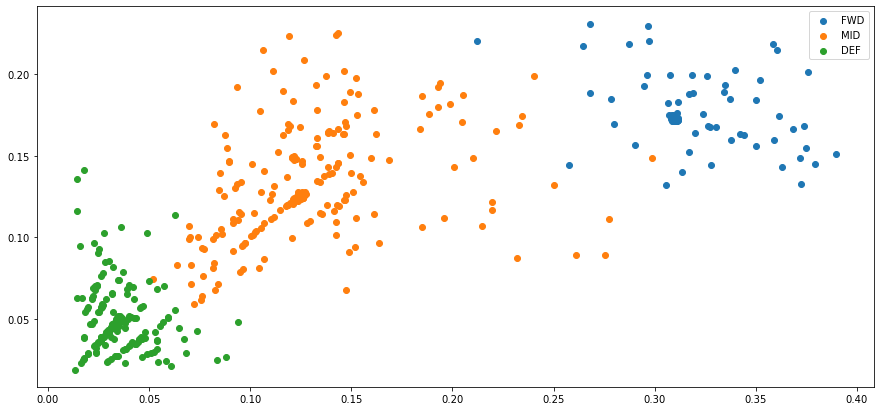

In [21]:
fig, ax = plt.subplots(figsize=(15,7))

ax.scatter(x=fwd_data['prob_score'], y=fwd_data['prob_assist'], label='FWD')
ax.scatter(x=mid_data['prob_score'], y=mid_data['prob_assist'], label='MID')
ax.scatter(x=def_data['prob_score'], y=def_data['prob_assist'], label='DEF')
#ax.scatter(x=gkp_data['pr_score'], y=gkp_data['pr_assist'], label='GKP')

plt.legend()
plt.show()

In [26]:
fwd_data['player_name'] = fwd_data['player_id'].map(id_player_dict)
mid_data['player_name'] = mid_data['player_id'].map(id_player_dict)

In [27]:
mid_data.sort_values(by='prob_score', ascending=False).head(10)

,player_id,prob_score,prob_assist,prob_neither,pos,player_name
222,543,0.298568,0.148688,0.552744,MID,Gareth_Bale_543
106,254,0.277331,0.111281,0.611387,MID,Mohamed_Salah_254
18,45,0.275497,0.089299,0.635204,MID,Anwar_El Ghazi_45
191,468,0.261006,0.089539,0.649455,MID,Diogo_Jota_468
3,18,0.250189,0.131944,0.617867,MID,Nicolas_Pépé_18
126,302,0.240127,0.199142,0.560731,MID,Bruno Miguel_Borges Fernandes_302
199,481,0.234596,0.174444,0.590960,MID,Matheus_Pereira_481
157,390,0.232739,0.169068,0.598193,MID,Heung-Min_Son_390
5,20,0.231872,0.087217,0.680911,MID,Joseph_Willock_20
120,287,0.221499,0.164868,0.613633,MID,Ferran_Torres_287


In [ ]:
player_names = pd.read_csv('./data/data/2020-21/players_raw.csv', usecols=['id', 'web_name'])
this_season_teams = pd.read_csv('./data/data/2021-22/players_raw.csv', usecols=['web_name', 'team'])

In [ ]:
fitted_data = pd.merge(fitted_data, player_names, left_on='player_id', right_on='id')

In [ ]:
fwd_data.sort_values('pr_assist', ascending=False).head()

In [ ]:
#remember to use the element table to get the most recent teams..

In [ ]:
#get player ids split by each position: defender, midfielder, forward